## Imports

In [1]:
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

## Read/Transform Data

In [2]:
VOCAB_SIZE = 16384
INPUT_LENGTH = 265
NUM_CLASSES = 5
epochs = 3

In [3]:
# read data
df = pd.read_csv('cleaned-data.csv')

In [4]:
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Lyric,Genres
0,you take your coat off and throw it on the flo...,Pop
1,whatever happened to this it was an island of ...,Pop
2,are you ready are you ready are you ready are ...,Rock
3,if you were here id whisper sweet nothings in ...,Heavy Metal
4,my heart beats a little bit slower these night...,Pop


In [5]:
indexNames = []
for index, row in df.iterrows():
    if len(row.Genres.split("; "))>1:
        indexNames.append(index)
df = df.drop(indexNames)

In [6]:
x = np.array(df['Lyric'])
y = np.array(df['Genres'])

<AxesSubplot:>

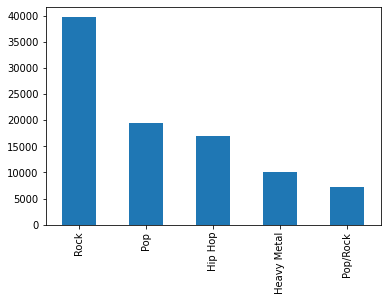

In [7]:
df['Genres'].value_counts().plot.bar()

In [8]:
# tokenizer to transform lyrics into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# updates internal vocabulary based on the lyrics
tokenizer.fit_on_texts(x)

# transform each text in x to a sequence of tokens
x = tokenizer.texts_to_sequences(x)

# pads/cuts sequences to the same length
x = pad_sequences(x, maxlen = INPUT_LENGTH)

# tokenizer to transform genres into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-.:;<=>?@[]^_`{|}~\t\n',
    lower=True, split='; ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# updates internal vocabulary based on the genres
tokenizer.fit_on_texts(y)

# transform each genre in y to an integer
y = tokenizer.texts_to_sequences(y)
y = np.array([elem[0]-1 for elem in y])

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = split(x, y)

In [10]:
print(set(y_val))

{0, 1, 2, 3, 4}


## Model

In [11]:
def LSTM_Model(features=256, dropout=0.7, units=256):
    model=Sequential()
    # Embedding layer
    model.add(Embedding(VOCAB_SIZE,features,input_length=INPUT_LENGTH))
    # Long Short Term Memory layer
    model.add(LSTM(units, dropout=dropout))
    # Output layer
    model.add(Dense(NUM_CLASSES,activation='sigmoid'))
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [12]:
model = LSTM_Model()
model.summary()

2022-07-06 00:05:04.570963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 00:05:04.620390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 00:05:04.620590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 00:05:04.621947: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 256)          4194304   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 4,720,901
Trainable params: 4,720,901
Non-trainable params: 0
_________________________________________________________________


## Validation and Testing

In [25]:
results = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=epochs)

Epoch 1/3
1757/1757 [==============================] - 148s 83ms/step - loss: 1.0439 - accuracy: 0.5328 - val_loss: 0.8473 - val_accuracy: 0.6335
Epoch 2/3
1757/1757 [==============================] - 146s 83ms/step - loss: 0.7740 - accuracy: 0.6639 - val_loss: 0.7528 - val_accuracy: 0.6816
Epoch 3/3
1757/1757 [==============================] - 146s 83ms/step - loss: 0.6727 - accuracy: 0.7188 - val_loss: 0.7345 - val_accuracy: 0.6919


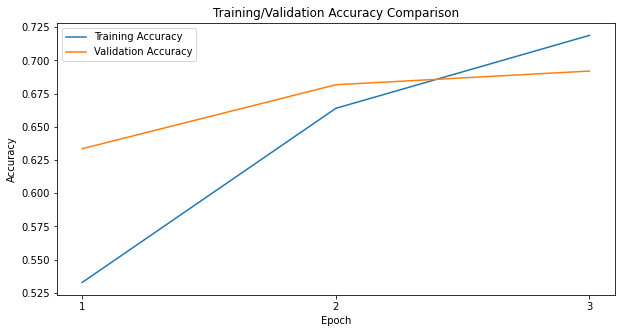

In [26]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

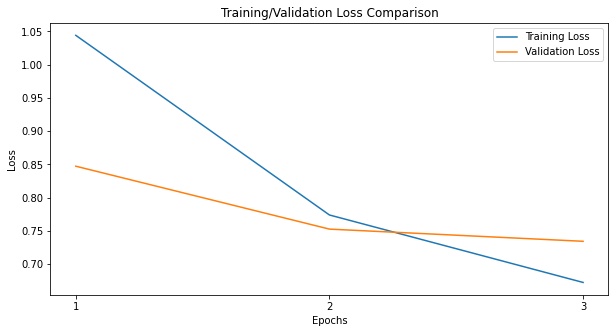

In [27]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

Epoch 1/3
   1/2342 [..............................] - ETA: 1:14:00 - loss: 1.6112 - accuracy: 0.1250

2022-07-06 00:05:07.524692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


2342/2342 [==============================] - 149s 63ms/step - loss: 1.1422 - accuracy: 0.5561
Epoch 2/3
2342/2342 [==============================] - 146s 62ms/step - loss: 0.8832 - accuracy: 0.6623
Epoch 3/3
586/586 [==============================] - 16s 26ms/step - loss: 0.8706 - accuracy: 0.6770
Test Loss: 0.8705766201019287
Test Accuracy: 0.6769682168960571


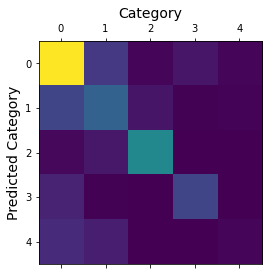

              precision    recall  f1-score   support

           0       0.79      0.69      0.74      9159
           1       0.53      0.50      0.51      4020
           2       0.84      0.84      0.84      3492
           3       0.66      0.74      0.70      1796
           4       0.07      0.37      0.12       268

    accuracy                           0.68     18735
   macro avg       0.58      0.63      0.58     18735
weighted avg       0.72      0.68      0.70     18735



In [13]:
model = LSTM_Model()
results = model.fit(np.concatenate((x_train,x_val)), np.concatenate((y_train,y_val)), epochs=epochs)
loss, acc = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

# show confusion matrix
y_pred=np.argmax(model.predict(x_test), axis=-1)
plot_confusion_matrix(y_test, y_pred)

# show other metrics
print(classification_report(y_pred,y_test))

## Hyper-Parameter Selection

### Epochs

In [16]:
model = LSTM_Model()
results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=10)

Epoch 1/10
1757/1757 [==============================] - 418s 237ms/step - loss: 1.0152 - accuracy: 0.5473 - val_loss: 0.8138 - val_accuracy: 0.6385
Epoch 2/10
1757/1757 [==============================] - 411s 234ms/step - loss: 0.7308 - accuracy: 0.6869 - val_loss: 0.7352 - val_accuracy: 0.6884
Epoch 3/10
1757/1757 [==============================] - 403s 229ms/step - loss: 0.6121 - accuracy: 0.7463 - val_loss: 0.7314 - val_accuracy: 0.6913
Epoch 4/10
1757/1757 [==============================] - 414s 235ms/step - loss: 0.5218 - accuracy: 0.7859 - val_loss: 0.7691 - val_accuracy: 0.6856
Epoch 5/10
1757/1757 [==============================] - 418s 238ms/step - loss: 0.4440 - accuracy: 0.8200 - val_loss: 0.8618 - val_accuracy: 0.6770
Epoch 6/10
1757/1757 [==============================] - 418s 238ms/step - loss: 0.3881 - accuracy: 0.8420 - val_loss: 0.9420 - val_accuracy: 0.6714
Epoch 7/10
1757/1757 [==============================] - 407s 232ms/step - loss: 0.3245 - accuracy: 0.8708 - val_

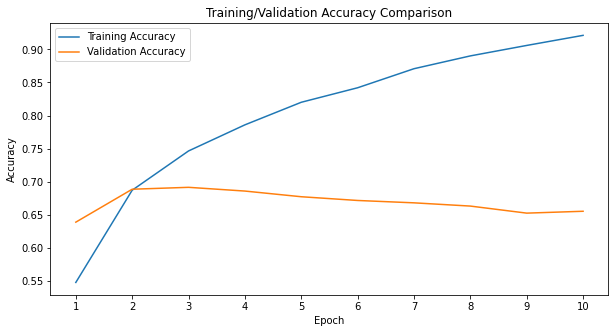

In [17]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

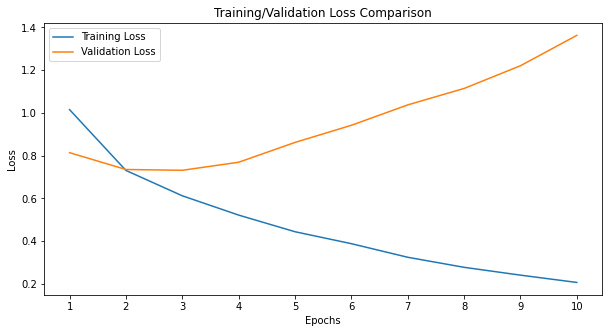

In [18]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

### Dropout Rate

In [13]:
dropout_rates=[]
acc = []
loss = []

dp = 0
while dp <= 0.8:
    model = LSTM_Model(dropout=dp)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    dropout_rates.append(round(dp,1))
    dp += 0.1

Epoch 1/3


2022-07-05 17:10:27.236892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1757/1757 [==============================] - 253s 109ms/step - loss: 0.9717 - accuracy: 0.5699 - val_loss: 0.7918 - val_accuracy: 0.6591
Epoch 2/3
1757/1757 [==============================] - 181s 103ms/step - loss: 0.7135 - accuracy: 0.6988 - val_loss: 0.7394 - val_accuracy: 0.6939
Epoch 3/3
1757/1757 [==============================] - 185s 105ms/step - loss: 0.5754 - accuracy: 0.7638 - val_loss: 0.7610 - val_accuracy: 0.6932
Epoch 1/3
1757/1757 [==============================] - 200s 113ms/step - loss: 0.9752 - accuracy: 0.5693 - val_loss: 0.7983 - val_accuracy: 0.6620
Epoch 2/3
1757/1757 [==============================] - 191s 109ms/step - loss: 0.7055 - accuracy: 0.7034 - val_loss: 0.7411 - val_accuracy: 0.6804
Epoch 3/3
1757/1757 [==============================] - 171s 97ms/step - loss: 0.5742 - accuracy: 0.7635 - val_loss: 0.7598 - val_accuracy: 0.6901
Epoch 1/3
1757/1757 [==============================] - 202s 114ms/step - loss: 0.9579 - accuracy: 0.5744 - val_loss: 0.7826 - val

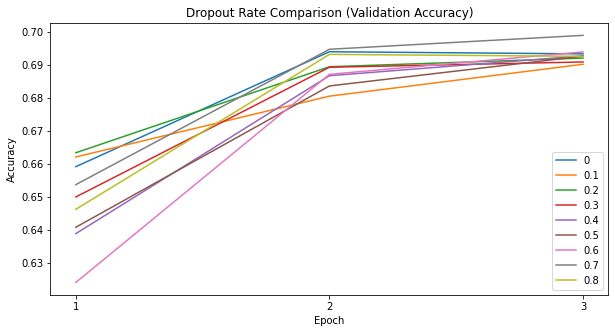

In [14]:
plot_accuracy_comparison(acc, "Dropout Rate Comparison (Validation Accuracy)", dropout_rates)

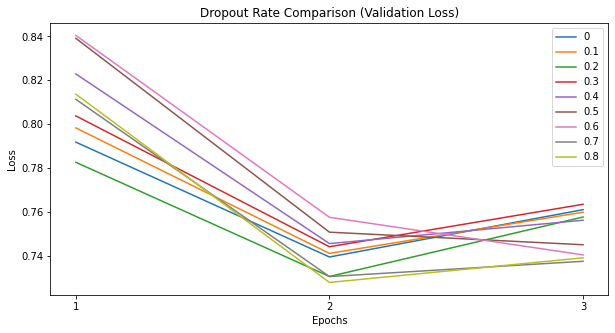

In [15]:
plot_loss_comparison(loss, "Dropout Rate Comparison (Validation Loss)", dropout_rates)

### Features

In [16]:
features=[]
acc = []
loss = []

f = 64
while f <= 512:
    model = LSTM_Model(features=f)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    features.append(f)
    f *= 2

Epoch 1/3
1757/1757 [==============================] - 93s 52ms/step - loss: 1.1122 - accuracy: 0.4971 - val_loss: 1.0355 - val_accuracy: 0.5410
Epoch 2/3
1757/1757 [==============================] - 89s 50ms/step - loss: 0.9005 - accuracy: 0.6031 - val_loss: 0.8369 - val_accuracy: 0.6416
Epoch 3/3
1757/1757 [==============================] - 88s 50ms/step - loss: 0.7541 - accuracy: 0.6673 - val_loss: 0.7688 - val_accuracy: 0.6678
Epoch 1/3
1757/1757 [==============================] - 100s 56ms/step - loss: 1.0854 - accuracy: 0.5186 - val_loss: 0.8577 - val_accuracy: 0.6282
Epoch 2/3
1757/1757 [==============================] - 102s 58ms/step - loss: 0.7779 - accuracy: 0.6623 - val_loss: 0.7660 - val_accuracy: 0.6713
Epoch 3/3
1757/1757 [==============================] - 107s 61ms/step - loss: 0.6932 - accuracy: 0.7085 - val_loss: 0.7506 - val_accuracy: 0.6844
Epoch 1/3
1757/1757 [==============================] - 137s 77ms/step - loss: 1.0005 - accuracy: 0.5527 - val_loss: 0.8387 - va

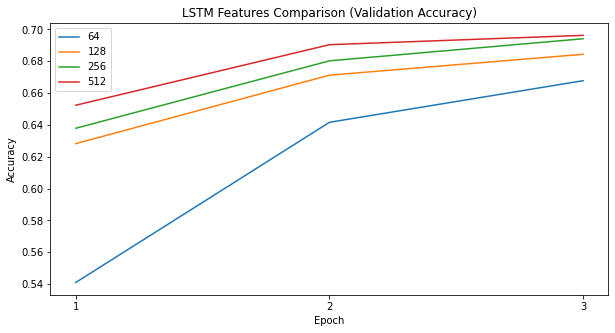

In [17]:
plot_accuracy_comparison(acc, "LSTM Features Comparison (Validation Accuracy)", features)

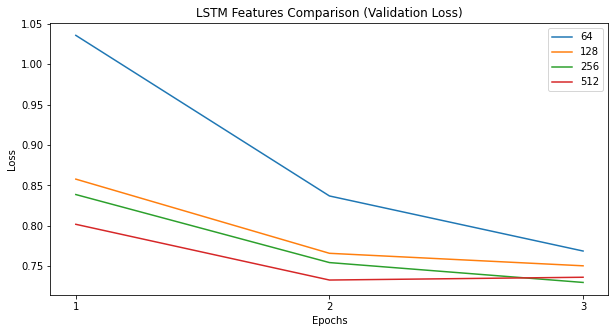

In [18]:
plot_loss_comparison(loss, "LSTM Features Comparison (Validation Loss)", features)

### Units

In [20]:
units=[]
acc = []
loss = []

u = 64
while u <= 512:
    model = LSTM_Model(units=u)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    units.append(u)
    u *= 2

Epoch 1/3
1757/1757 [==============================] - 73s 41ms/step - loss: 1.0233 - accuracy: 0.5430 - val_loss: 0.9864 - val_accuracy: 0.5750
Epoch 2/3
1757/1757 [==============================] - 75s 42ms/step - loss: 0.8559 - accuracy: 0.6335 - val_loss: 0.9167 - val_accuracy: 0.5944
Epoch 3/3
1757/1757 [==============================] - 75s 43ms/step - loss: 0.7827 - accuracy: 0.6705 - val_loss: 0.8096 - val_accuracy: 0.6652
Epoch 1/3
1757/1757 [==============================] - 103s 57ms/step - loss: 1.0284 - accuracy: 0.5450 - val_loss: 0.9417 - val_accuracy: 0.5918
Epoch 2/3
1757/1757 [==============================] - 100s 57ms/step - loss: 0.8397 - accuracy: 0.6370 - val_loss: 0.8326 - val_accuracy: 0.6362
Epoch 3/3
1757/1757 [==============================] - 100s 57ms/step - loss: 0.7306 - accuracy: 0.6876 - val_loss: 0.7564 - val_accuracy: 0.6778
Epoch 1/3
1757/1757 [==============================] - 170s 95ms/step - loss: 1.0331 - accuracy: 0.5348 - val_loss: 0.8323 - va

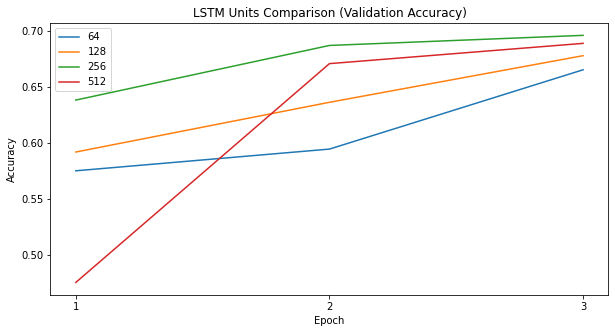

In [21]:
plot_accuracy_comparison(acc, "LSTM Units Comparison (Validation Accuracy)", units)

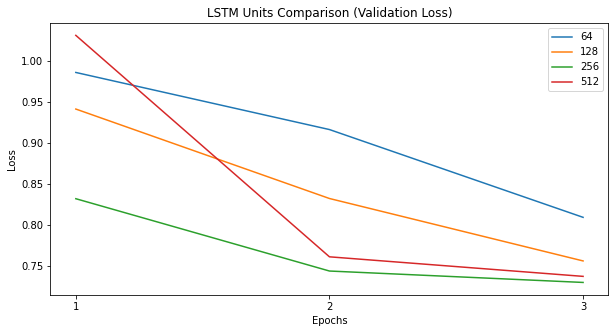

In [22]:
plot_loss_comparison(loss, "LSTM Units Comparison (Validation Loss)", units)